# **Composer classification Model**
___

#### **Problem Statement**

We are going to be working with the MIDI files of classical music composers. We will be using the MIDI files to classify the composer of the music. We will be using the MIDI files of the following composers: Bach Beethoven, chopin and Mozart. We will be building a CNN network to classify the composers, and we will also be making functions that will make the process of dealing with the midi files easier to work with. The objective is to get the classification model to be at approximately 90% accuracy, or better. 

In [1]:
# standard libraries
import os
import time
import pretty_midi
import numpy as np
import polars as pl
import pandas as pd
from mido import KeySignatureError
from concurrent.futures import ProcessPoolExecutor, as_completed
import matplotlib.pyplot as plt
import seaborn as sns


# deep learning libraries
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import StandardScaler, LabelEncoder
from sklearn.metrics import roc_auc_score, accuracy_score, f1_score, precision_score, recall_score, confusion_matrix, classification_report
from sklearn.feature_selection import SelectFromModel
from sklearn.ensemble import RandomForestClassifier
import torch
import torch.nn as nn
import torch.optim as optim
import torch.nn.functional as F
from torch.utils.data import DataLoader, TensorDataset
import torch.cuda.amp as amp

In [2]:
# midi file path and the composers in the file path
main_dir = 'midiclassics'
composers = ['Chopin', 'Beethoven', 'Bach', 'Mozart']

In [3]:
# function to calculate notes density
def calculate_notes_density(midi_data, max_sequence_length=300):
    total_notes = sum(len(instr.notes) for instr in midi_data.instruments)
    duration = midi_data.get_end_time()
    density = total_notes / duration
    return density

In [4]:
# function to extract features from the midi files, will need to change when adding more features to model
def extract_features(midi_file, max_sequence_length=300):
    try:
        midi_data = pretty_midi.PrettyMIDI(midi_file)
    except KeySignatureError as e:
        print(f"Failed to process {midi_file} due to key signature error: {e}")
        return None, None
    except Exception as e:
        print(f"Failed to process {midi_file} due to error: {e}")
        return None, None

    features = {}

    # tempo
    features['tempo'] = midi_data.estimate_tempo()

    # handling key signatures errors that happen with some midi files 
    try:
        features['key_signatures'] = [key.key_number for key in midi_data.key_signature_changes]
    except KeySignatureError as e:
        print(f"Key signature error in file {midi_file}: {e}")
        features['key_signatures'] = [0]  # Default to C major/A minor if error occurs
    except Exception as e:
        print(f"General error in file {midi_file}: {e}")
        features['key_signatures'] = [0]

    # getting the time signatures
    features['time_signatures'] = [(time.numerator, time.denominator) for time in midi_data.time_signature_changes]

    # instrument types
    features['instrument_types'] = [instr.program for instr in midi_data.instruments]

    # notes hist 
    histogram = np.zeros(12)
    for instrument in midi_data.instruments:
        for note in instrument.notes:
            pitch_class = note.pitch % 12
            histogram[pitch_class] += 1
    if np.sum(histogram) > 0:
        histogram /= np.sum(histogram)
    features['notes_histogram'] = histogram

    # notes matrix
    notes = np.zeros((max_sequence_length, 128))
    end_time = midi_data.get_end_time()
    for instrument in midi_data.instruments:
        for note in instrument.notes:
            start = int(note.start * max_sequence_length / end_time)
            end = int(note.end * max_sequence_length / end_time)
            notes[start:end, note.pitch] = note.velocity / 127
    features['notes_matrix'] = notes

    # Chroma features
    features['chroma'] = get_chroma(midi_data)

    # Notes density
    features['notes_density'] = calculate_notes_density(midi_data)
    
    ############################### Note onsets
    onsets = [note.start for instr in midi_data.instruments for note in instr.notes]
    features['note_onsets'] = len(onsets) / end_time if end_time > 0 else 0

    # Polyphony
    times = np.arange(0, end_time, 0.1)
    polyphony = [sum(1 for note in instr.notes if note.start <= t <= note.end) for instr in midi_data.instruments for t in times]
    features['polyphony'] = np.mean(polyphony)

    # Note durations
    durations = [note.end - note.start for instr in midi_data.instruments for note in instr.notes]
    features['note_duration_mean'] = np.mean(durations)
    features['note_duration_variance'] = np.var(durations)

    # Velocity
    velocities = [note.velocity for instr in midi_data.instruments for note in instr.notes]
    features['velocity_mean'] = np.mean(velocities)
    features['velocity_variance'] = np.var(velocities)

    # Pitch bend
    pitch_bends = [bend.pitch for instr in midi_data.instruments for bend in instr.pitch_bends]
    features['pitch_bend_mean'] = np.mean(pitch_bends) if pitch_bends else 0
    features['pitch_bend_variance'] = np.var(pitch_bends) if pitch_bends else 0

    return features, os.path.basename(midi_file)

In [5]:
# function to get chroma features
def get_chroma(midi_data, fs=100):
    chroma = midi_data.get_chroma(fs=fs)
    return chroma

In [6]:
def process_composer(composer):
    composer_folder = os.path.join(main_dir, composer)
    composer_data = []
    composer_labels = []
    for file in os.listdir(composer_folder):
        if file.endswith('.midi') or file.endswith('.mid') or file.endswith('.MID'):
            file_path = os.path.join(composer_folder, file)
            start_time = time.time()
            try:
                features, filename = extract_features(file_path)
                end_time = time.time()
                if features is not None:
                    processing_time = end_time - start_time
                    print(f"Processed {filename} by {composer} in {processing_time:.2f} seconds")
                    composer_data.append(features)
                    composer_labels.append(composer)
                else:
                    print(f"Skipping file {file_path} by {composer} due to extraction error.")
            except Exception as e:
                print(f"Failed to process {file_path} by {composer}: {e}")
    return composer_data, composer_labels

In [7]:
if __name__ == "__main__":
    data = []
    labels = []

    # process each composer sequentially
    for composer in composers:
        composer_data, composer_labels = process_composer(composer)
        data.extend(composer_data)
        labels.extend(composer_labels)

    print("Processing complete.")

Processed (2542)Prelude opus.28, No.16 in B flat minor.mid by Chopin in 0.11 seconds
Processed 19 Polish Songs, for Solo Voice and Piano accomplements, No.10.mid by Chopin in 0.20 seconds


c:\Users\tehwh\anaconda3\envs\ml\lib\site-packages\pretty_midi\pretty_midi.py:100: RuntimeWarning: Tempo, Key or Time signature change events found on non-zero tracks.  This is not a valid type 0 or type 1 MIDI file.  Tempo, Key or Time Signature may be wrong.
  warnings.warn(


Processed 19 Polish Songs, for Solo Voice and Piano accomplements, No.11.mid by Chopin in 0.06 seconds
Processed 19 Polish Songs, for Solo Voice and Piano accomplements, No.12.mid by Chopin in 0.13 seconds
Processed 19 Polish Songs, for Solo Voice and Piano accomplements, No.13.mid by Chopin in 0.20 seconds
Processed 19 Polish Songs, for Solo Voice and Piano accomplements, No.14.mid by Chopin in 0.06 seconds
Processed 19 Polish Songs, for Solo Voice and Piano accomplements, No.15.mid by Chopin in 0.15 seconds
Processed 19 Polish Songs, for Solo Voice and Piano accomplements, No.16.mid by Chopin in 0.13 seconds
Processed 19 Polish Songs, for Solo Voice and Piano accomplements, No.17.mid by Chopin in 0.29 seconds
Processed 19 Polish Songs, for Solo Voice and Piano accomplements, No.18.mid by Chopin in 0.20 seconds
Processed 19 Polish Songs, for Solo Voice and Piano accomplements, No.19.mid by Chopin in 0.02 seconds
Processed 19 Polish Songs, for Solo Voice and Piano accomplements, No.2.m

In [71]:
# converting the data to a pandas dataframe and the labels to a numpy array
data_pl = pl.DataFrame(data)
data_df = data_pl.to_pandas()
labels = np.array(labels)

In [72]:
def preprocess_features(df):
    # flatten the complex features
    df['key_signatures'] = df['key_signatures'].apply(lambda x: x[:1] if len(x) > 0 else [0])  # Use first key signature
    df['instrument_types'] = df['instrument_types'].apply(lambda x: x[:1] if len(x) > 0 else [0])  # Use first instrument type
    df['notes_histogram'] = df['notes_histogram'].apply(lambda x: x[:12] if len(x) >= 12 else np.zeros(12))  # Ensure length 12
    
    # Ensure consistent size for 'notes_matrix' and 'chroma'
    max_sequence_length = 300
    df['notes_matrix'] = df['notes_matrix'].apply(lambda x: x.flatten() if x.size == max_sequence_length * 128 else np.pad(x.flatten(), (0, max_sequence_length * 128 - x.size), 'constant'))
    
    # concat into a single array
    feature_array = np.hstack([
        df['tempo'].values.reshape(-1, 1),
        np.vstack(df['key_signatures']),
        np.vstack(df['instrument_types']),
        np.vstack(df['notes_histogram']),
        np.vstack(df['notes_matrix']),
        df['notes_density'].values.reshape(-1, 1),
        df['note_onsets'].values.reshape(-1, 1),
        df['polyphony'].values.reshape(-1, 1),
        df['note_duration_mean'].values.reshape(-1, 1),
        df['note_duration_variance'].values.reshape(-1, 1),
        df['velocity_mean'].values.reshape(-1, 1),
        df['velocity_variance'].values.reshape(-1, 1),
        df['pitch_bend_mean'].values.reshape(-1, 1),
        df['pitch_bend_variance'].values.reshape(-1, 1),
    ])
    
    return feature_array

In [90]:
# checking the columns of the df 
data_df.columns

Index(['tempo', 'key_signatures', 'time_signatures', 'instrument_types',
       'notes_histogram', 'notes_matrix', 'chroma', 'notes_density',
       'note_onsets', 'polyphony', 'note_duration_mean',
       'note_duration_variance', 'velocity_mean', 'velocity_variance',
       'pitch_bend_mean', 'pitch_bend_variance'],
      dtype='object')

In [91]:
# checking the feature array 
feature_array = preprocess_features(data_df)
feature_array.shape

(1627, 38424)

In [92]:
# Encode the labels
label_encoder = LabelEncoder()
encoded_labels = label_encoder.fit_transform(labels)

In [93]:
# Standardize the features
scaler = StandardScaler()
scaled_features = scaler.fit_transform(preprocess_features(data_df))

# Model Architecture

In [94]:
# pre processing the data for the model
features = preprocess_features(data_df)

In [95]:
# ecoding the labels
label_encoder = LabelEncoder()
encoded_labels = label_encoder.fit_transform(labels)

In [96]:
# standardizing the features 
scaler = StandardScaler()
scaled_features = scaler.fit_transform(features)

In [97]:
# reshaping the features 
scaled_features = scaled_features.reshape(scaled_features.shape[0], 1, scaled_features.shape[1])

In [98]:
# setting the batch size
batch_size = 32

# splitting the data into training and testing sets
X_train, X_val, y_train, y_val = train_test_split(scaled_features, encoded_labels, test_size=0.2, random_state=42)

In [99]:
# define the model
class CNNLSTMClassifier(nn.Module):
    def __init__(self, input_size, hidden_size, num_layers, num_classes):
        super(CNNLSTMClassifier, self).__init__()
        self.hidden_size = hidden_size
        self.num_layers = num_layers
        self.conv1 = nn.Conv1d(1, 32, kernel_size=3, padding=1)
        self.conv2 = nn.Conv1d(32, 64, kernel_size=3, padding=1)
        self.pool = nn.MaxPool1d(kernel_size=2, stride=2)
        self.lstm = nn.LSTM(64, hidden_size, num_layers, batch_first=True)
        self.fc = nn.Linear(hidden_size, num_classes)
    
    def forward(self, x):
        x = self.pool(F.relu(self.conv1(x)))
        x = self.pool(F.relu(self.conv2(x)))
        x = x.permute(0, 2, 1)
        h0 = torch.zeros(self.num_layers, x.size(0), self.hidden_size).to(x.device)
        c0 = torch.zeros(self.num_layers, x.size(0), self.hidden_size).to(x.device)
        out, _ = self.lstm(x, (h0, c0))
        out = self.fc(out[:, -1, :])
        return out

In [100]:
# create a dataset and dataloader
X_train_tensor = torch.tensor(X_train, dtype=torch.float32)
X_val_tensor = torch.tensor(X_val, dtype=torch.float32)
y_train_tensor = torch.tensor(y_train, dtype=torch.long)
y_val_tensor = torch.tensor(y_val, dtype=torch.long)

In [101]:
# data loaders to device
train_loader = DataLoader(TensorDataset(X_train_tensor, y_train_tensor), batch_size=batch_size, shuffle=True, num_workers=3)
val_loader = DataLoader(TensorDataset(X_val_tensor, y_val_tensor), batch_size=batch_size, shuffle=False, num_workers=2)

In [102]:
# hyperparameters
input_size = X_train_tensor.shape[2]
hidden_size = 128
num_layers = 2
num_classes = len(np.unique(y_train))
num_epochs = 20
learning_rate = 0.001
patience = 5

In [103]:
# checking cuda 
print(torch.cuda.is_available())
print(torch.cuda.device_count())
print(torch.cuda.get_device_name(0))
device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')
print(f"Using device: {device}")

True
1
NVIDIA GeForce RTX 2060
Using device: cuda


In [104]:
# Early stopping parameters
best_val_loss = float('inf')
epochs_no_improve = 2

In [105]:
# Initialize the model, loss function, and optimizer
model = CNNLSTMClassifier(input_size, hidden_size, num_layers, num_classes).to(device)
criterion = nn.CrossEntropyLoss()
optimizer = torch.optim.Adam(model.parameters(), lr=learning_rate)
scaler = torch.cuda.amp.GradScaler()

C:\Users\tehwh\AppData\Local\Temp\ipykernel_28156\962088949.py:5: FutureWarning: `torch.cuda.amp.GradScaler(args...)` is deprecated. Please use `torch.amp.GradScaler('cuda', args...)` instead.
  scaler = torch.cuda.amp.GradScaler()


In [106]:
# Early stopping parameters
best_loss = float('inf')
epochs_no_improve = 0

In [107]:
# Training the model with mixed precision
model.train()
for epoch in range(num_epochs):
    epoch_start_time = time.time()  # Start timer for epoch
    running_loss = 0.0
    
    for i, (X_batch, y_batch) in enumerate(train_loader):
        optimizer.zero_grad()
        
        X_batch, y_batch = X_batch.to(device), y_batch.to(device)
        
        with torch.cuda.amp.autocast():
            outputs = model(X_batch)
            loss = criterion(outputs, y_batch)
        
        scaler.scale(loss).backward()
        scaler.step(optimizer)
        scaler.update()
        
        running_loss += loss.item()
        
        # Print the loss for batches
        print(f'Epoch [{epoch+1}/{num_epochs}], Batch [{i+1}/{len(train_loader)}], Loss: {loss.item():.4f}')
    
    avg_loss = running_loss / len(train_loader)
    print(f'Epoch [{epoch+1}/{num_epochs}], Average Loss: {avg_loss:.4f}')
    
    epoch_end_time = time.time()  # End timer for epoch
    epoch_duration = epoch_end_time - epoch_start_time  # Calculate epoch duration
    print(f'Epoch [{epoch+1}/{num_epochs}] Duration: {epoch_duration:.2f} seconds')
    
    # Eealr stoping
    if avg_loss < best_loss:
        best_loss = avg_loss
        epochs_no_improve = 0
        # save model 
        torch.save(model.state_dict(), 'best_model.pt')
    else:
        epochs_no_improve += 1
        if epochs_no_improve >= patience:
            print("Early stopping!")
            break

# 7 min run time with first model

C:\Users\tehwh\AppData\Local\Temp\ipykernel_28156\53498172.py:12: FutureWarning: `torch.cuda.amp.autocast(args...)` is deprecated. Please use `torch.amp.autocast('cuda', args...)` instead.
  with torch.cuda.amp.autocast():


Epoch [1/20], Batch [1/41], Loss: 1.3839
Epoch [1/20], Batch [2/41], Loss: 1.3846
Epoch [1/20], Batch [3/41], Loss: 1.3580
Epoch [1/20], Batch [4/41], Loss: 1.3347
Epoch [1/20], Batch [5/41], Loss: 1.2920
Epoch [1/20], Batch [6/41], Loss: 1.2174
Epoch [1/20], Batch [7/41], Loss: 1.2684
Epoch [1/20], Batch [8/41], Loss: 1.1161
Epoch [1/20], Batch [9/41], Loss: 1.1592
Epoch [1/20], Batch [10/41], Loss: 1.3717
Epoch [1/20], Batch [11/41], Loss: 0.8797
Epoch [1/20], Batch [12/41], Loss: 1.2487
Epoch [1/20], Batch [13/41], Loss: 1.2420
Epoch [1/20], Batch [14/41], Loss: 0.9276
Epoch [1/20], Batch [15/41], Loss: 0.9685
Epoch [1/20], Batch [16/41], Loss: 0.9964
Epoch [1/20], Batch [17/41], Loss: 1.1204
Epoch [1/20], Batch [18/41], Loss: 0.9083
Epoch [1/20], Batch [19/41], Loss: 0.9417
Epoch [1/20], Batch [20/41], Loss: 1.0801
Epoch [1/20], Batch [21/41], Loss: 0.7148
Epoch [1/20], Batch [22/41], Loss: 1.1320
Epoch [1/20], Batch [23/41], Loss: 1.3632
Epoch [1/20], Batch [24/41], Loss: 0.8893
E

In [108]:
# loading the best model for evals
model.load_state_dict(torch.load('best_model.pt'))

C:\Users\tehwh\AppData\Local\Temp\ipykernel_28156\2693154534.py:2: FutureWarning: You are using `torch.load` with `weights_only=False` (the current default value), which uses the default pickle module implicitly. It is possible to construct malicious pickle data which will execute arbitrary code during unpickling (See https://github.com/pytorch/pytorch/blob/main/SECURITY.md#untrusted-models for more details). In a future release, the default value for `weights_only` will be flipped to `True`. This limits the functions that could be executed during unpickling. Arbitrary objects will no longer be allowed to be loaded via this mode unless they are explicitly allowlisted by the user via `torch.serialization.add_safe_globals`. We recommend you start setting `weights_only=True` for any use case where you don't have full control of the loaded file. Please open an issue on GitHub for any issues related to this experimental feature.
  model.load_state_dict(torch.load('best_model.pt'))


<All keys matched successfully>

In [111]:
# model evaluation
model.eval()
correct_test = 0
total_test = 0
with torch.no_grad():
    for i, (X_batch, y_batch) in enumerate(val_loader):
        start_time = time.time()
        X_batch, y_batch = X_batch.to(device), y_batch.to(device)
        outputs = model(X_batch)
        _, predicted = torch.max(outputs.data, 1)
        total_test += y_batch.size(0)
        correct_test += (predicted == y_batch).sum().item()
        end_time = time.time()
        batch_time = end_time - start_time
        # print progress
        print(f'Batch [{i+1}/{len(val_loader)}] processed in {batch_time:.2f} seconds')
        
accuracy_test = 100 * correct_test / total_test
print(f'Test Accuracy: {accuracy_test:.2f}%')

Batch [1/11] processed in 10.75 seconds
Batch [2/11] processed in 10.88 seconds
Batch [3/11] processed in 10.66 seconds
Batch [4/11] processed in 10.69 seconds
Batch [5/11] processed in 11.27 seconds
Batch [6/11] processed in 11.06 seconds
Batch [7/11] processed in 11.11 seconds
Batch [8/11] processed in 11.08 seconds
Batch [9/11] processed in 10.90 seconds
Batch [10/11] processed in 10.81 seconds
Batch [11/11] processed in 1.46 seconds
Test Accuracy: 76.99%


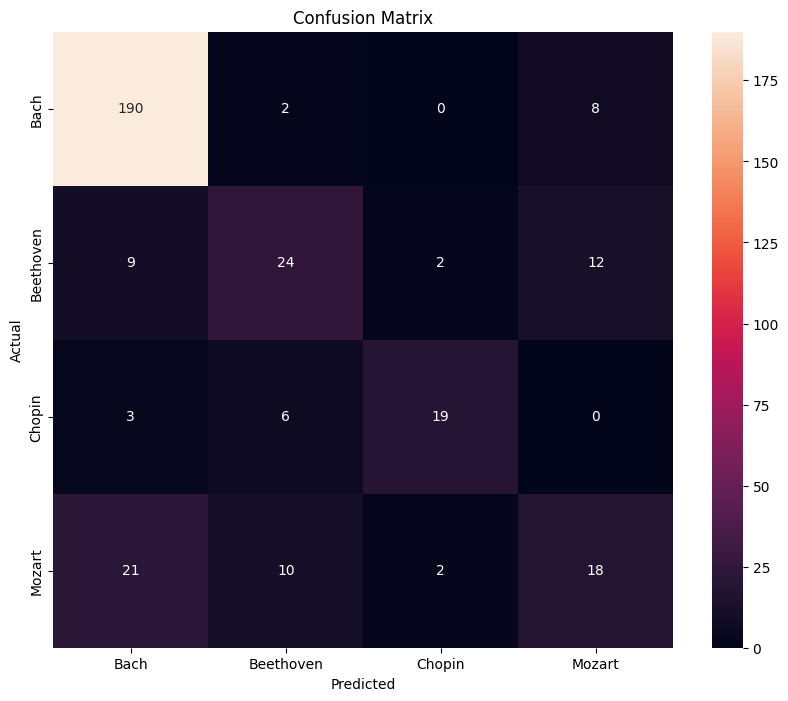

In [113]:
# plotting the confusion matrix
model.eval()
y_pred = []
y_true = []
with torch.no_grad():
    for i, (X_batch, y_batch) in enumerate(val_loader):
        X_batch, y_batch = X_batch.to(device), y_batch.to(device)
        outputs = model(X_batch)
        _, predicted = torch.max(outputs.data, 1)
        y_pred.extend(predicted.cpu().numpy())
        y_true.extend(y_batch.cpu().numpy())
        
cm = confusion_matrix(y_true, y_pred)
plt.figure(figsize=(10, 8))
sns.heatmap(cm, annot=True, fmt='d', xticklabels=label_encoder.classes_, yticklabels=label_encoder.classes_)
plt.xlabel('Predicted')
plt.ylabel('Actual')
plt.title('Confusion Matrix')
plt.show()

In [114]:
# F1 score, precision, recall, and accuracy on the model 
f1 = f1_score(y_true, y_pred, average='weighted')
precision = precision_score(y_true, y_pred, average='weighted')
recall = recall_score(y_true, y_pred, average='weighted')
accuracy = accuracy_score(y_true, y_pred)

# printing the metrics
print(f'F1 Score: {f1:.4f}')
print(f'Precision: {precision:.4f}')
print(f'Recall: {recall:.4f}')
print(f'Accuracy: {accuracy:.4f}')

F1 Score: 0.7562
Precision: 0.7502
Recall: 0.7699
Accuracy: 0.7699


In [116]:
# classification report
print(classification_report(y_true, y_pred, target_names=label_encoder.classes_))

              precision    recall  f1-score   support

        Bach       0.85      0.95      0.90       200
   Beethoven       0.57      0.51      0.54        47
      Chopin       0.83      0.68      0.75        28
      Mozart       0.47      0.35      0.40        51

    accuracy                           0.77       326
   macro avg       0.68      0.62      0.65       326
weighted avg       0.75      0.77      0.76       326

